In [51]:
#|default_exp tmp

# Resnet18d working

In [1]:
#| export
import pickle,gzip,math,os,time,shutil,torch,random
import fastcore.all as fc,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

import torchvision.transforms.functional as TF,torch.nn.functional as F
from torchvision import transforms
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *
from miniai.resnet import *
from miniai.augment import *
from miniai.challange.ct94ep5 import *
from miniai.utils import *
from miniai.accel import *
import timm

In [2]:
# torch.backends.cudnn.benchmark = True
# torch.backends.cudnn.deterministic = False 

In [3]:
from fastcore.test import test_close
from torch import distributions

torch.set_printoptions(precision=8, linewidth=140, sci_mode=False)
mpl.rcParams['image.cmap'] = 'gray'

import logging
logging.disable(logging.WARNING)

if fc.defaults.cpus>8: fc.defaults.cpus=8

In [4]:
RNG = RNGSeedCB(verbose=True)
RNG.set_seed(1)

Reseed: 1


1

In [5]:
xl,yl = 'image','label'
name = "fashion_mnist"
bs = 256
xmean,xstd = 0.28, 0.35

@inplace
def transformi(b): b[xl] = [(TF.to_tensor(o)-xmean)/xstd for o in b[xl]]

dsd = load_dataset(name)
tds = dsd.with_transform(transformi)

  0%|          | 0/2 [00:00<?, ?it/s]

In [6]:
tds.cached = cache_dataset_as_dict(tds)

In [7]:
metrics = LazyMetricsCB(accuracy=MulticlassAccuracy())

def multi_kw(f):
    def kw(*dicts, **kwargs):
        r = {}
        for d in (*dicts, kwargs):
            for k, v in d.items():
                if k in r and isinstance(r, (list, tuple)): 
                    r[k] = [*r[k], *v]
                elif k not in r:
                    r[k] = v
                else:
                    print(f"duplicate key {k} ")
        return f(**r)
    kw.__wrapped__=f
    return kw


@multi_kw
def run(model, leaky=0.0003, m=1, cbs=tuple(), fit=True, train_cb=MixedPrecision(), epochs=5, base_lr=2e-2, 
        loss_func=F.cross_entropy, bs=bs, tta=False, dls=None, verbose=False, 
        sched_fn=lr_scheduler.OneCycleLR, opt_func=optim.AdamW):
    iw = partial(init_weights, leaky=leaky) if leaky is not None else fc.noop
    lr = base_lr*m
    print("Batch size", bs*m)
    dls = dls or DataLoaders.from_dd(tds.cached, bs*m, num_workers=0) 
    tmax = epochs * len(dls.train)
    sched = partial(sched_fn, max_lr=lr, total_steps=tmax)
    
    cbs = [DeviceCB(), RNG, metrics, BatchSchedCB(sched), *cbs, train_cb] 
    learn = Learner(model.apply(iw), dls, loss_func, lr=lr, cbs=cbs, opt_func=opt_func)
    if verbose: 
        print(torch.randn([3]))
        print(next(iter(learn.dls.train))[1])
    if fit:
        learn.fit(epochs, cbs=[TimeItCB(), LazyProgressCB(plot=epochs>1)])
    if tta:
        ## TTA
        ap1, at = learn.capture_preds()
        ttacb = BatchTransformCB(partial(tfm_batch, tfm_x=TF.hflip), on_val=True)
        ap2, at = learn.capture_preds(cbs=[ttacb])
        ap = torch.stack([ap1,ap2]).mean(0).argmax(1)
        print('TTA:', round((ap==at).float().mean().item(), 4))
        
    return learn

### Setup base model from 13_resnet

In [8]:
# The last resnet model 92.8% 5epochs
def model_base_resnet():
    def get_model(act=nn.ReLU, nfs=(8,16,32,64,128,256), norm=nn.BatchNorm2d):
        layers = [ResBlock(1, 8, stride=1, act=act, norm=norm)]
        layers += [ResBlock(nfs[i], nfs[i+1], act=act, norm=norm, stride=2) for i in range(len(nfs)-1)]
        layers += [nn.Flatten(), nn.Linear(nfs[-1], 10, bias=False), nn.BatchNorm1d(10)]
        return nn.Sequential(*layers).to(def_device)
    RNG.previous()
    act_gr = partial(GeneralRelu, leak=0.1, sub=0.4)
    
    return dict(model=get_model(act_gr, norm=nn.BatchNorm2d), leaky=0.1)

Reseed: 2
Reseed: 2
Batch size 1024
Reseed: 2


accuracy,loss,epoch,train
0.804,0.743,0,train
0.817,0.614,0,eval
0.891,0.355,1,train
0.892,0.333,1,eval
0.915,0.257,2,train
0.889,0.318,2,eval
0.934,0.198,3,train
0.924,0.222,3,eval
0.955,0.143,4,train
0.928,0.216,4,eval


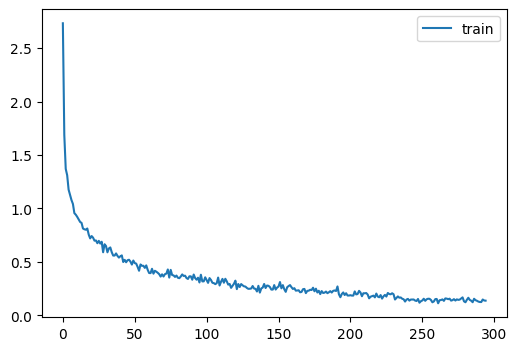

Fit 5 in: 14.64s, setup: 0.00s, 2.78 ± 0.44s per epoch, 0.02 ± 0.06s per batch


In [12]:
RNG.set_seed(2)
learn = run(**model_base_resnet(), bs=1024, base_lr=2e-2, train_cb=TrainCB())

Reseed: 1
Reseed: 1
Batch size 256
Reseed: 1


accuracy,loss,epoch,train
0.842,0.612,0,train
0.868,0.422,0,eval
0.891,0.335,1,train
0.893,0.324,1,eval
0.914,0.249,2,train
0.900,0.283,2,eval
0.935,0.191,3,train
0.926,0.209,3,eval
0.953,0.139,4,train
0.932,0.196,4,eval


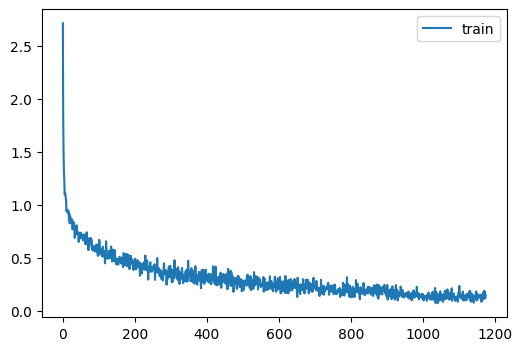

Fit 5 in: 20.34s, setup: 0.00s, 3.87 ± 0.02s per epoch, 0.01 ± 0.00s per batch


In [13]:
RNG.set_seed(1)
learn = run(**model_base_resnet(), base_lr=1e-2, train_cb=TrainCB())

### Upscale for resnet

In [9]:
#| export
class Upscale:
    def __init__(self, sz, align=True, const=0): fc.store_attr() 
    def _sz(self, n): return round(self.sz*n / 32)*32 if self.align else self.sz*n
    def antialiased(self, n): 
        return transforms.Resize(self._sz(n), transforms.InterpolationMode.BILINEAR, antialias=True)
    def bilinear(self, n): 
        return transforms.Resize(self._sz(n), transforms.InterpolationMode.BILINEAR, antialias=False)
    def bicubica(self, n): 
        return transforms.Resize(self._sz(n), transforms.InterpolationMode.BICUBIC, antialias=True)
    def bicubic(self, n): 
        return transforms.Resize(self._sz(n), transforms.InterpolationMode.BICUBIC, antialias=False)
    def nearest(self, n): 
        return transforms.Resize(self._sz(n), transforms.InterpolationMode.NEAREST)
    def pad(self, n): 
        return transforms.Pad((self._sz(n)-self.sz)//2, padding_mode='constant', fill=self.const)

In [10]:
upscale32 = Upscale(28, align=True, const=-0.800000011920929)
upscale = Upscale(28, align=False, const=-0.800000011920929)

In [11]:
RNG.previous()
learn = run(model=get_model(), epochs=1)
xb,yb = learn.batch

Reseed: 1
Batch size 256
Reseed: 1


accuracy,loss,epoch,train
0.795,0.580,0,train
0.859,0.375,0,eval


Fit 1 in: 2.73s, setup: 0.00s, 2.67 ± 0.00s per epoch, 0.01 ± 0.10s per batch


In [12]:
xb.shape, upscale32.bilinear(4)(xb).shape,upscale32.pad(4)(xb).shape

(torch.Size([272, 1, 28, 28]),
 torch.Size([272, 1, 128, 128]),
 torch.Size([272, 1, 128, 128]))

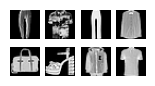

In [13]:
def show_actual_size(ims):
    sz = ims.shape[-1]
    show_images(ims, imsize=sz / 64)
show_actual_size(xb[:8])

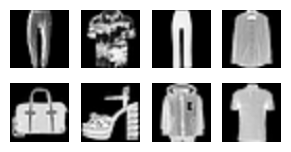

In [14]:
show_actual_size(upscale.bilinear(2)(xb)[:8])

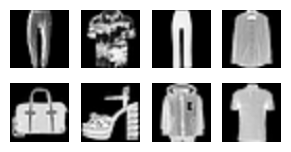

In [15]:
show_actual_size(upscale.bilinear(2)(upscale.bilinear(2)(xb))[:8])

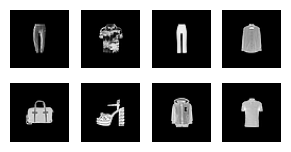

In [16]:
show_actual_size(upscale.pad(2)(xb)[:8])

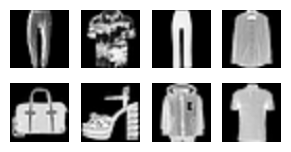

In [17]:
show_actual_size(upscale.antialiased(2)(xb)[:8])

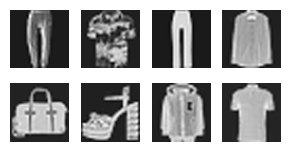

In [18]:
show_actual_size(upscale.bicubic(2)(xb)[:8])

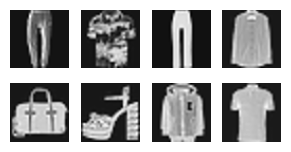

In [19]:
show_actual_size(upscale.bicubica(2)(xb)[:8])

### Timm model upscale, pad, vs noop

> Changes in batchsize does not have any significant impact on training speed

In [11]:
#| export
def timm_model(name, resize=nn.Identity(), leaky=0.0, **kw):
    RNG.previous()
    props = dict(in_chans=1, num_classes=10, pretrained=False)
    props.update(kw)
    model = nn.Sequential( 
        resize,
        timm.create_model(name, **props)
    )
    return dict(model=model, leaky=leaky)

In [12]:
# Cristopher Thomas 94.9% 5epochs
def model9_ct(**kw):
    from miniai.challange.ct94ep5 import get_model9
    RNG.previous()
    return dict(model=get_model9(Mish, norm=nn.BatchNorm2d), base_lr=1e-2, leaky=0.0003) | kw

### Select resnet scale

In [107]:
learn = run(timm_model('resnet18d', nn.Identity(), leaky=0.0), epochs=1)

Reseed: 1
Batch size 256
Reseed: 1


accuracy,loss,epoch,train
0.721,0.812,0,train
0.838,0.446,0,eval


Fit 1 in: 4.82s, setup: 0.00s, 4.71 ± 0.00s per epoch, 0.02 ± 0.01s per batch


In [110]:
learn = run(timm_model('resnet18d', upscale32.pad(2)), leaky=0.0, epochs=1)

Reseed: 1
duplicate key leaky 
Batch size 256
Reseed: 1


accuracy,loss,epoch,train
0.709,0.913,0,train
0.822,0.506,0,eval


Fit 1 in: 6.93s, setup: 0.00s, 6.71 ± 0.00s per epoch, 0.03 ± 0.02s per batch


In [50]:
learn = run(timm_model('resnet18d', upscale32.nearest(2)), leaky=0.0, epochs=1)

Reseed: 1
Batch size 256
Reseed: 1


accuracy,loss,epoch,train
0.847,0.434,0,train
0.911,0.241,0,eval


Fit 1 in: 6.64s, setup: 0.00s, 6.42 ± 0.00s per epoch, 0.03 ± 0.00s per batch


In [51]:
learn = run(timm_model('resnet18d', upscale32.bilinear(2)), leaky=0.0, epochs=1)

Reseed: 1
Batch size 256
Reseed: 1


accuracy,loss,epoch,train
0.848,0.430,0,train
0.911,0.240,0,eval


Fit 1 in: 6.65s, setup: 0.00s, 6.42 ± 0.00s per epoch, 0.03 ± 0.00s per batch


In [92]:
learn = run(timm_model('resnet18d', upscale32.bicubic(2)), leaky=0.0, epochs=1)

Reseed: 1
duplicate key leaky 
Batch size 256
Reseed: 1


accuracy,loss,epoch,train
0.847,0.435,0,train
0.911,0.241,0,eval


Fit 1 in: 6.85s, setup: 0.00s, 6.62 ± 0.00s per epoch, 0.03 ± 0.01s per batch


In [93]:
learn = run(timm_model('resnet18d', upscale32.bicubica(2)), leaky=0.0, epochs=1)

Reseed: 1
duplicate key leaky 
Batch size 256
Reseed: 1


accuracy,loss,epoch,train
0.849,0.432,0,train
0.910,0.243,0,eval


Fit 1 in: 6.66s, setup: 0.00s, 6.43 ± 0.00s per epoch, 0.03 ± 0.00s per batch


In [94]:
learn = run(timm_model('resnet18d', upscale32.bicubic(4)), leaky=0.0, epochs=1)

Reseed: 1
duplicate key leaky 
Batch size 256
Reseed: 1


accuracy,loss,epoch,train
0.832,0.479,0,train
0.911,0.249,0,eval


Fit 1 in: 17.25s, setup: 0.00s, 16.54 ± 0.00s per epoch, 0.07 ± 0.00s per batch


In [95]:
learn = run(timm_model('resnet18d', upscale32.bilinear(4)), leaky=0.0, epochs=1)

Reseed: 1
duplicate key leaky 
Batch size 256
Reseed: 1


accuracy,loss,epoch,train
0.828,0.492,0,train
0.908,0.257,0,eval


Fit 1 in: 17.47s, setup: 0.00s, 16.77 ± 0.00s per epoch, 0.07 ± 0.02s per batch


In [96]:
learn = run(timm_model('resnet18d', upscale32.nearest(4)), leaky=0.0, epochs=1)

Reseed: 1
duplicate key leaky 
Batch size 256
Reseed: 1


accuracy,loss,epoch,train
0.831,0.483,0,train
0.909,0.251,0,eval


Fit 1 in: 17.37s, setup: 0.00s, 16.68 ± 0.00s per epoch, 0.07 ± 0.01s per batch


In [52]:
learn = run(model_base_resnet(), epochs=1)

Reseed: 1
Batch size 256
Reseed: 1


accuracy,loss,epoch,train
0.859,0.461,0,train
0.899,0.287,0,eval


Fit 1 in: 4.23s, setup: 0.00s, 4.13 ± 0.00s per epoch, 0.02 ± 0.00s per batch


In [53]:
learn = run(model9_ct(), epochs=1)

Reseed: 1
Batch size 256
Reseed: 1


accuracy,loss,epoch,train
0.875,0.448,0,train
0.913,0.278,0,eval


Fit 1 in: 17.81s, setup: 0.00s, 16.97 ± 0.00s per epoch, 0.07 ± 0.00s per batch


### 5 Epoch

Reseed: 1
Reseed: 1
Batch size 256
Reseed: 1


accuracy,loss,epoch,train
0.848,0.561,0,train
0.845,0.458,0,eval
0.891,0.320,1,train
0.875,0.405,1,eval
0.912,0.248,2,train
0.908,0.265,2,eval
0.931,0.194,3,train
0.924,0.210,3,eval
0.950,0.142,4,train
0.933,0.192,4,eval


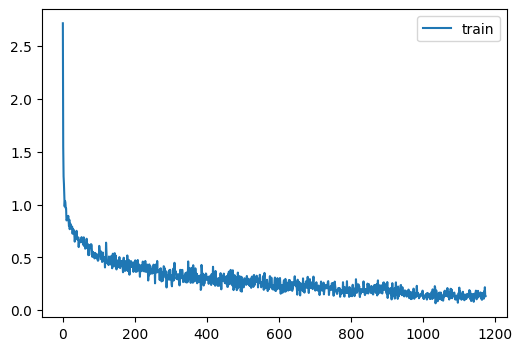

Fit 5 in: 22.24s, setup: 0.00s, 4.27 ± 0.14s per epoch, 0.02 ± 0.00s per batch


In [46]:
RNG.set_seed(1)
learn = run(model_base_resnet())

Reseed: 1
Batch size 256
Reseed: 1


accuracy,loss,epoch,train
0.837,0.474,0,train
0.652,1.057,0,eval
0.904,0.265,1,train
0.906,0.271,1,eval
0.926,0.201,2,train
0.902,0.275,2,eval
0.947,0.145,3,train
0.933,0.192,3,eval
0.967,0.092,4,train
0.942,0.173,4,eval


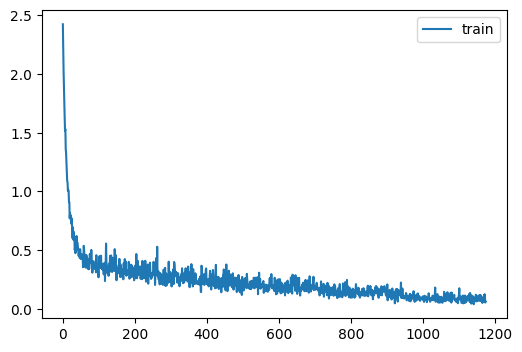

Fit 5 in: 34.43s, setup: 0.00s, 6.58 ± 0.08s per epoch, 0.03 ± 0.00s per batch


In [66]:
learn = run(timm_model('resnet18d', upscale32.bilinear(2), leaky=0.0))

Reseed: 1
Batch size 256
Reseed: 1


accuracy,loss,epoch,train
0.868,0.543,0,train
0.878,0.394,0,eval
0.909,0.289,1,train
0.891,0.344,1,eval
0.930,0.208,2,train
0.919,0.230,2,eval
0.952,0.145,3,train
0.936,0.187,3,eval
0.975,0.082,4,train
0.942,0.183,4,eval


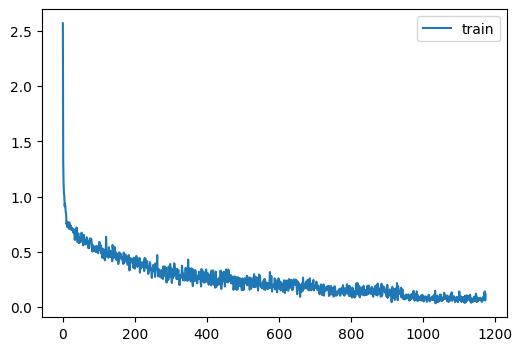

Fit 5 in: 96.07s, setup: 0.00s, 17.25 ± 0.10s per epoch, 0.07 ± 0.01s per batch


In [67]:
learn = run(model9_ct())

## Curriculum learning on FP16

> It doesn't make a difference for fp16

In [13]:
def curriculum():
    return dict(dls=CustomDataLoader.from_dd(tds.cached, bs, num_workers=0), 
                cbs=[TopLossesCallback(n={
            0: 0,
            1: 0.21,
            2: 0.42,
            3: 0.21,
            4: 0
    })])

Reseed: 1
Batch size 256
Reseed: 1


accuracy,loss,epoch,train
0.849,0.561,0,train
0.868,0.400,0,eval
0.818,0.489,1,train
0.749,0.649,1,eval
0.815,0.476,2,train
0.859,0.346,2,eval
0.880,0.304,3,train
0.926,0.215,3,eval
0.974,0.084,4,train
0.935,0.203,4,eval


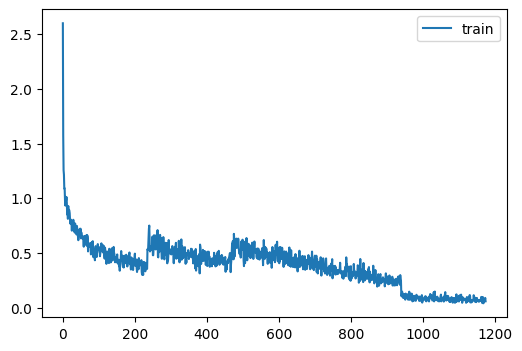

/home/piotr/miniconda3/envs/miniai/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


Replacing top 12600 expamples out of 60000
Replacing top 25200 expamples out of 60000
Replacing top 12600 expamples out of 60000
Fit 5 in: 23.24s, setup: 0.00s, 4.39 ± 0.15s per epoch, 0.02 ± 0.01s per batch


In [56]:
learn = run(model_base_resnet(), curriculum(), epochs=5)

Reseed: 1
Batch size 256
Reseed: 1


accuracy,loss,epoch,train
0.865,0.553,0,train
0.878,0.394,0,eval
0.853,0.421,1,train
0.913,0.257,1,eval
0.878,0.335,2,train
0.928,0.213,2,eval
0.964,0.113,3,train
0.937,0.226,3,eval
0.998,0.024,4,train
0.940,0.221,4,eval


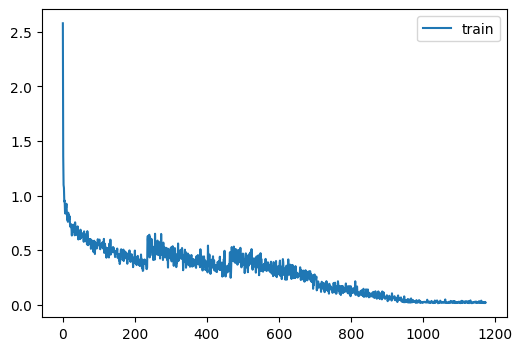

Replacing top 12600 expamples out of 60000
Replacing top 25200 expamples out of 60000
Replacing top 12600 expamples out of 60000
Fit 5 in: 90.92s, setup: 0.00s, 17.26 ± 0.12s per epoch, 0.07 ± 0.01s per batch


In [57]:
learn = run(model9_ct(), curriculum())

Reseed: 1
Batch size 256
Reseed: 1


accuracy,loss,epoch,train
0.833,0.483,0,train
0.874,0.374,0,eval
0.847,0.407,1,train
0.913,0.240,1,eval
0.858,0.363,2,train
0.919,0.227,2,eval
0.936,0.165,3,train
0.937,0.227,3,eval
0.994,0.019,4,train
0.941,0.240,4,eval


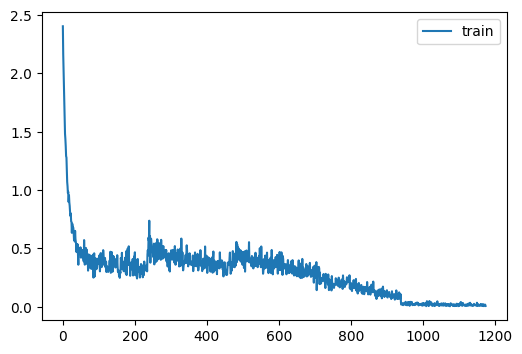

/home/piotr/miniconda3/envs/miniai/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


Replacing top 12600 expamples out of 60000
Replacing top 25200 expamples out of 60000
Replacing top 12600 expamples out of 60000
Fit 5 in: 35.29s, setup: 0.00s, 6.73 ± 0.13s per epoch, 0.03 ± 0.01s per batch


In [43]:
learn = run(timm_model('resnet18d', upscale32.bilinear(2), leaky=0.0,),  curriculum())

### Resnet with augment & curriculum learning

In [14]:
class DelayedBatchTransformCB(BatchTransformCB):
    def __init__(self, *args,epoch=0,**kwargs): 
        super().__init__(*args, **kwargs)
        self.epoch=epoch
    def before_batch(self, learn):
        if self.epoch <= learn.epoch: 
            super().before_batch(learn)
        
def tfm_batch(b, tfm_x=fc.noop, tfm_y = fc.noop): return tfm_x(b[0]),tfm_y(b[1])
def get_augcb(*ag, delay=0):
    tfms = nn.Sequential(*ag)
    return dict(cbs=[DelayedBatchTransformCB(partial(tfm_batch, tfm_x=tfms), on_val=False, epoch=delay)])

Reseed: 1
Batch size 256
Reseed: 1


accuracy,loss,epoch,train
0.827,0.502,0,train
0.779,0.708,0,eval
0.896,0.285,1,train
0.857,0.399,1,eval
0.920,0.219,2,train
0.900,0.263,2,eval
0.938,0.168,3,train
0.931,0.184,3,eval
0.956,0.119,4,train
0.939,0.172,4,eval


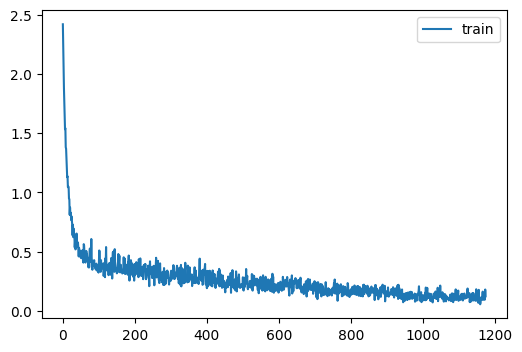

Fit 5 in: 34.38s, setup: 0.00s, 6.57 ± 0.01s per epoch, 0.03 ± 0.00s per batch


In [36]:
learn = run(timm_model('resnet18d', upscale32.bilinear(2), leaky=0.0),
            get_augcb(transforms.RandomHorizontalFlip(0.5)))

Reseed: 1
Batch size 256
Reseed: 1


accuracy,loss,epoch,train
0.812,0.533,0,train
0.837,0.515,0,eval
0.888,0.302,1,train
0.888,0.340,1,eval
0.914,0.232,2,train
0.909,0.250,2,eval
0.932,0.181,3,train
0.932,0.189,3,eval
0.949,0.139,4,train
0.938,0.174,4,eval


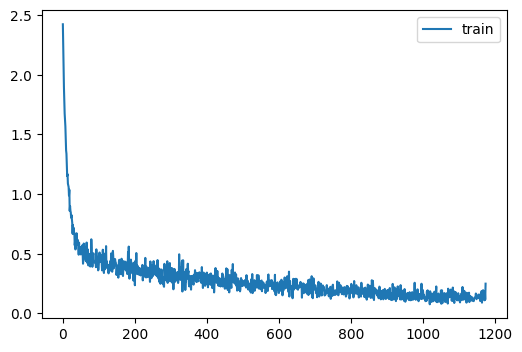

Fit 5 in: 34.47s, setup: 0.00s, 6.59 ± 0.10s per epoch, 0.03 ± 0.01s per batch


In [30]:
learn = run(timm_model('resnet18d', upscale32.bilinear(2), leaky=0.0), get_augcb(transforms.RandomCrop(28, padding=1)))

In [33]:
xb[0,0,0,0].item()

-0.800000011920929

Reseed: 1
Batch size 256
Reseed: 1


accuracy,loss,epoch,train
0.810,0.536,0,train
0.870,0.365,0,eval
0.889,0.302,1,train
0.873,0.366,1,eval
0.913,0.235,2,train
0.916,0.234,2,eval
0.933,0.182,3,train
0.936,0.184,3,eval
0.948,0.141,4,train
0.941,0.171,4,eval


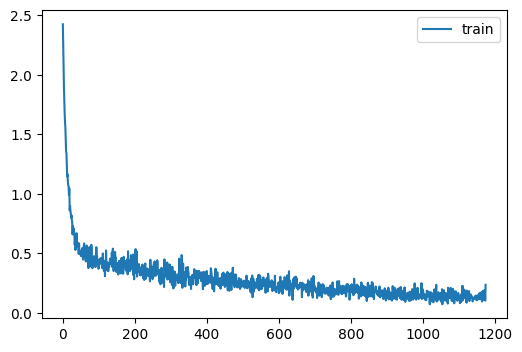

Fit 5 in: 35.79s, setup: 0.00s, 6.85 ± 0.73s per epoch, 0.03 ± 0.05s per batch


In [15]:
learn = run(timm_model('resnet18d', upscale32.bilinear(2), leaky=0.0), get_augcb(transforms.RandomCrop(28, padding=1, fill=-0.800000011920929)))

In [93]:
upscale32.bilinear(2)(xb).shape

torch.Size([272, 1, 64, 64])

Reseed: 1
Reseed: 1
Batch size 256
Reseed: 1


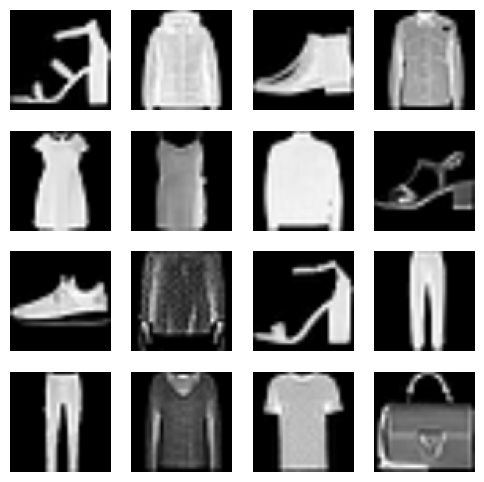

In [18]:
RNG.set_seed(1)
run(timm_model('resnet18d', upscale32.bilinear(2), leaky=0.0), 
    get_augcb(upscale32.bilinear(2),
             transforms.RandomCrop(64, padding=1, fill=-0.800000011920929)), fit=False).show_image_batch(max_n=16, imsize=(1.5))

Reseed: 1
Batch size 256
Reseed: 1


accuracy,loss,epoch,train
0.829,0.493,0,train
0.808,0.539,0,eval
0.898,0.279,1,train
0.905,0.273,1,eval
0.921,0.214,2,train
0.916,0.238,2,eval
0.942,0.158,3,train
0.932,0.193,3,eval
0.958,0.114,4,train
0.941,0.169,4,eval


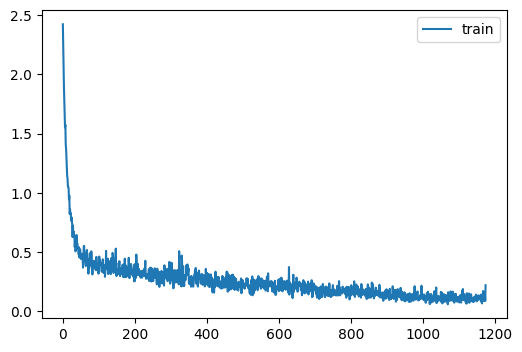

Fit 5 in: 34.35s, setup: 0.00s, 6.57 ± 0.06s per epoch, 0.03 ± 0.00s per batch


In [19]:
learn = run(timm_model('resnet18d', upscale32.bilinear(2), leaky=0.0), 
            get_augcb(upscale32.bilinear(2),
                      transforms.RandomCrop(64, padding=1, fill=-0.800000011920929)))

Reseed: 1
Batch size 256
Reseed: 1


accuracy,loss,epoch,train
0.801,0.567,0,train
0.679,1.628,0,eval
0.885,0.318,1,train
0.858,0.438,1,eval
0.909,0.247,2,train
0.901,0.287,2,eval
0.929,0.192,3,train
0.928,0.202,3,eval
0.943,0.155,4,train
0.938,0.173,4,eval


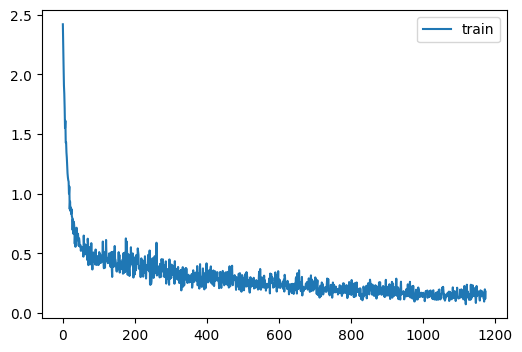

Fit 5 in: 34.79s, setup: 0.00s, 6.66 ± 0.13s per epoch, 0.03 ± 0.01s per batch


In [37]:
learn = run(timm_model('resnet18d', upscale32.bilinear(2), leaky=0.0),
            get_augcb(transforms.RandomCrop(28, padding=1, fill=-0.800000011920929), transforms.RandomHorizontalFlip(0.5)))

Reseed: 1
Reseed: 1
Batch size 256
Reseed: 1


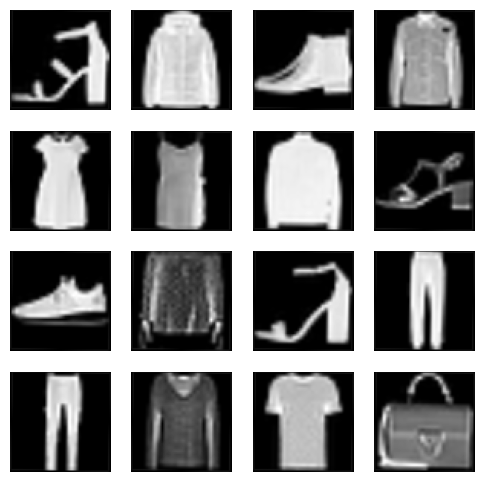

In [20]:
RNG.set_seed(1)
learn = run(timm_model('resnet18d', upscale32.bilinear(2),leaky=0.0),
            get_augcb(
                upscale32.bilinear(2),
                transforms.RandomRotation(1, fill=-0.800000011920929, expand=True, interpolation=transforms.InterpolationMode.BILINEAR),
            ), fit=False)
learn.show_image_batch(max_n=16, imsize=(1.5))

In [21]:
learn.fit(5, cbs=ProgressCB())

Reseed: 1


accuracy,loss,epoch,train
0.839,0.464,0,train
0.763,0.800,0,eval
0.900,0.273,1,train
0.871,0.381,1,eval
0.924,0.207,2,train
0.916,0.231,2,eval
0.944,0.152,3,train
0.930,0.195,3,eval
0.964,0.099,4,train
0.937,0.182,4,eval


Reseed: 1
Reseed: 1
Batch size 256
Reseed: 1


accuracy,loss,epoch,train
0.833,0.482,0,train
0.417,7.805,0,eval
0.903,0.267,1,train
0.132,19.767,1,eval
0.926,0.203,2,train
0.450,7.190,2,eval
0.946,0.149,3,train
0.245,13.420,3,eval
0.966,0.094,4,train
0.800,1.032,4,eval


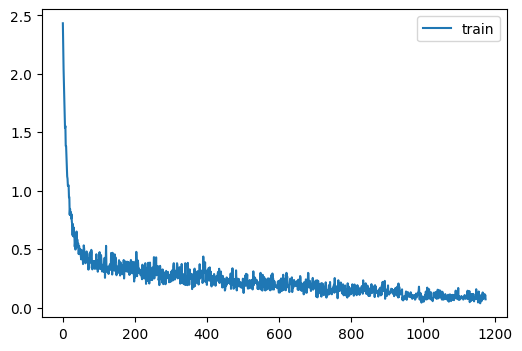

Fit 5 in: 34.21s, setup: 0.00s, 6.54 ± 0.12s per epoch, 0.03 ± 0.01s per batch


In [37]:
RNG.set_seed(1)
learn = run(timm_model('resnet18d', upscale32.bilinear(2),leaky=0.0),
            get_augcb(
                transforms.RandomAutocontrast(),
            ))

Reseed: 1
Reseed: 1
Batch size 256
Reseed: 1


accuracy,loss,epoch,train
0.814,0.539,0,train
0.391,5.528,0,eval
0.889,0.305,1,train
0.780,0.735,1,eval
0.910,0.241,2,train
0.684,1.468,2,eval
0.933,0.181,3,train
0.482,2.648,3,eval
0.952,0.128,4,train
0.901,0.284,4,eval


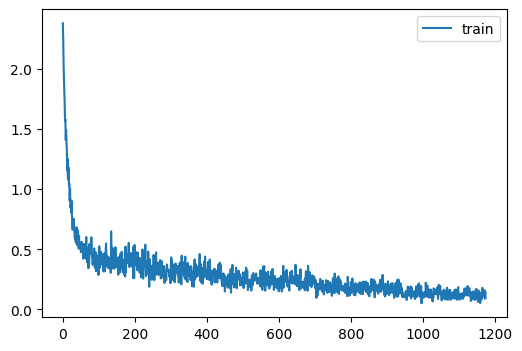

Fit 5 in: 34.43s, setup: 0.00s, 6.58 ± 0.09s per epoch, 0.03 ± 0.00s per batch


In [30]:
RNG.set_seed(1)
learn = run(timm_model('resnet18d', upscale32.bilinear(2),leaky=0.0),
            get_augcb(
                upscale32.bilinear(2),
                transforms.RandomAdjustSharpness(2),
            ))

Reseed: 1
Batch size 256
Reseed: 1


accuracy,loss,epoch,train
0.798,0.568,0,train
0.736,0.824,0,eval
0.880,0.328,1,train
0.862,0.415,1,eval
0.908,0.250,2,train
0.870,0.372,2,eval
0.927,0.197,3,train
0.929,0.201,3,eval
0.942,0.157,4,train
0.934,0.182,4,eval


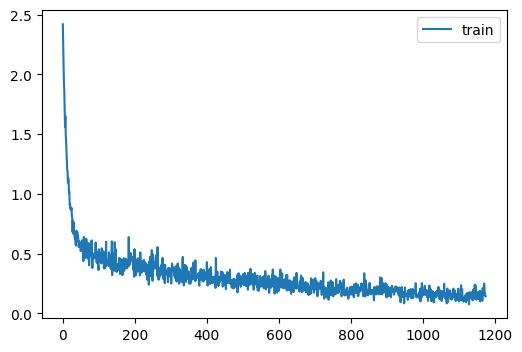

Fit 5 in: 35.85s, setup: 0.00s, 6.87 ± 0.12s per epoch, 0.03 ± 0.01s per batch


In [41]:
learn = run(timm_model('resnet18d', upscale32.bilinear(2), leaky=0.0),
            get_augcb(
                transforms.RandomCrop(28, padding=1, fill=-0.800000011920929),
                upscale32.bilinear(2),
                transforms.RandomRotation(1, fill=-0.800000011920929, expand=True, interpolation=transforms.InterpolationMode.BILINEAR),
                transforms.RandomHorizontalFlip(0.5)))

## 20 epochs

Reseed: 1
Batch size 256
Reseed: 1


accuracy,loss,epoch,train
0.811,0.541,0,train
0.853,0.397,0,eval
0.880,0.325,1,train
0.872,0.366,1,eval
0.894,0.287,2,train
0.862,0.364,2,eval
0.904,0.262,3,train
0.868,0.371,3,eval
0.908,0.247,4,train
0.904,0.258,4,eval


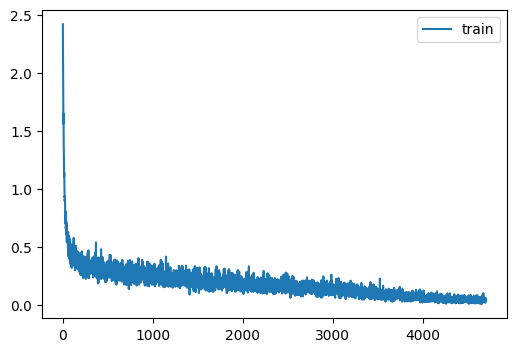

Fit 20 in: 142.82s, setup: 0.00s, 6.83 ± 0.06s per epoch, 0.03 ± 0.00s per batch
Reseed: 1
Reseed: 1
TTA: 0.9487


In [44]:
learn = run(timm_model('resnet18d', upscale32.bilinear(2), leaky=0.0),
            get_augcb(
                transforms.RandomCrop(28, padding=1, fill=-0.800000011920929),
                upscale32.bilinear(2),
                transforms.RandomRotation(1, fill=-0.800000011920929, expand=True, interpolation=transforms.InterpolationMode.BILINEAR),
                transforms.RandomHorizontalFlip(0.5)), epochs=20, tta=True)

Reseed: 1
Batch size 256
Reseed: 1


accuracy,loss,epoch,train
0.783,0.621,0,train
0.836,0.466,0,eval
0.862,0.374,1,train
0.860,0.410,1,eval
0.879,0.330,2,train
0.874,0.358,2,eval
0.890,0.298,3,train
0.896,0.294,3,eval
0.897,0.279,4,train
0.903,0.289,4,eval


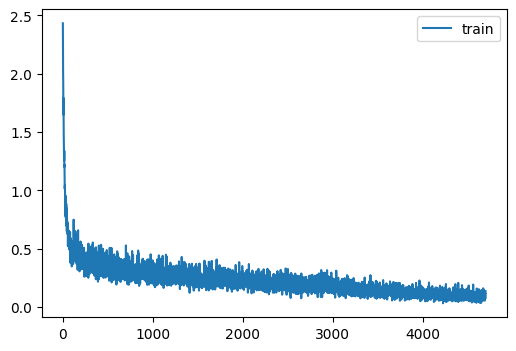

Fit 20 in: 144.61s, setup: 0.00s, 6.93 ± 0.05s per epoch, 0.03 ± 0.00s per batch
Reseed: 1
Reseed: 1
TTA: 0.9492


In [46]:
learn = run(timm_model('resnet18d', upscale32.bilinear(2), leaky=0.0),
            get_augcb(
                transforms.RandomCrop(28, padding=1, fill=-0.800000011920929),
                upscale32.bilinear(2),
                transforms.RandomRotation(1, fill=-0.800000011920929, expand=True, interpolation=transforms.InterpolationMode.BILINEAR),
                transforms.RandomHorizontalFlip(0.5),
                RandErase()), epochs=20, tta=True)

Reseed: 1
Batch size 256
Reseed: 1


accuracy,loss,epoch,train
0.719,0.784,0,train
0.819,0.593,0,eval
0.812,0.507,1,train
0.766,0.722,1,eval
0.836,0.440,2,train
0.778,0.796,2,eval
0.855,0.394,3,train
0.847,0.450,3,eval
0.861,0.373,4,train
0.681,1.059,4,eval


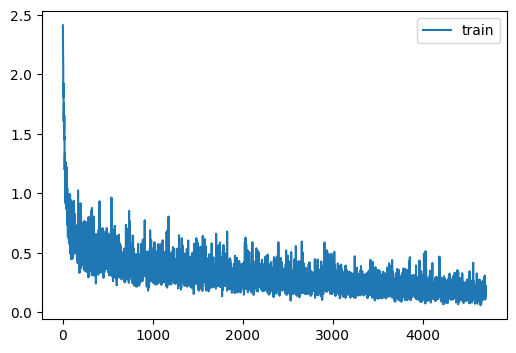

Fit 20 in: 143.99s, setup: 0.00s, 6.90 ± 0.07s per epoch, 0.03 ± 0.00s per batch
Reseed: 1
Reseed: 1
TTA: 0.9452


In [48]:
learn = run(timm_model('resnet18d', upscale32.bilinear(2), leaky=0.0),
            get_augcb(
                transforms.RandomCrop(28, padding=1, fill=-0.800000011920929),
                upscale32.bilinear(2),
                transforms.RandomRotation(1, fill=-0.800000011920929, expand=True, interpolation=transforms.InterpolationMode.BILINEAR),
                transforms.RandomHorizontalFlip(0.5),
                RandErase(pct=0.4)), epochs=20, tta=True)

In [ ]:
# drop rate 0.4

Reseed: 1
Batch size 256
Reseed: 1


accuracy,loss,epoch,train
0.769,0.653,0,train
0.854,0.423,0,eval
0.857,0.388,1,train
0.864,0.405,1,eval
0.875,0.342,2,train
0.850,0.438,2,eval
0.887,0.311,3,train
0.853,0.411,3,eval
0.889,0.299,4,train
0.848,0.460,4,eval


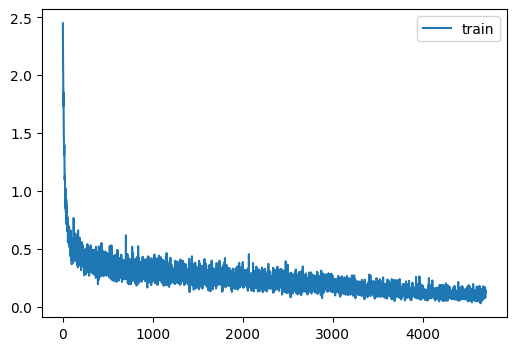

Fit 20 in: 144.04s, setup: 0.00s, 6.90 ± 0.07s per epoch, 0.03 ± 0.00s per batch
Reseed: 1
Reseed: 1
TTA: 0.9483


In [49]:
learn = run(timm_model('resnet18d', upscale32.bilinear(2), leaky=0.0,  drop_rate=0.4),
            get_augcb(
                transforms.RandomCrop(28, padding=1, fill=-0.800000011920929),
                upscale32.bilinear(2),
                transforms.RandomRotation(1, fill=-0.800000011920929, expand=True, interpolation=transforms.InterpolationMode.BILINEAR),
                transforms.RandomHorizontalFlip(0.5),
                RandErase(pct=0.2)), epochs=20, tta=True)

In [52]:
learn.fit(20,cbs=ProgressCB())

Reseed: 1


accuracy,loss,epoch,train
0.974,0.074,0,train
0.945,0.191,0,eval
0.956,0.121,1,train
0.934,0.203,1,eval
0.943,0.158,2,train
0.931,0.209,2,eval
0.931,0.191,3,train
0.895,0.307,3,eval
0.923,0.215,4,train
0.900,0.301,4,eval


Reseed: 1
Batch size 256
Reseed: 1


accuracy,loss,epoch,train
0.743,0.722,0,train
0.808,0.560,0,eval
0.838,0.436,1,train
0.833,0.538,1,eval
0.861,0.382,2,train
0.782,0.692,2,eval
0.872,0.350,3,train
0.841,0.448,3,eval
0.878,0.334,4,train
0.850,0.456,4,eval


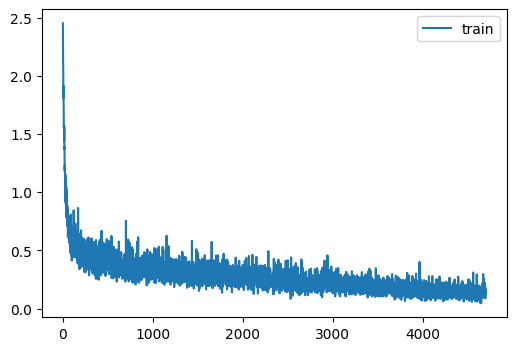

Fit 20 in: 144.28s, setup: 0.00s, 6.91 ± 0.08s per epoch, 0.03 ± 0.00s per batch
Reseed: 1
Reseed: 1
TTA: 0.9478


In [53]:
learn = run(timm_model('resnet18d', upscale32.bilinear(2), leaky=0.0,  drop_rate=0.4),
            get_augcb(
                transforms.RandomCrop(28, padding=1, fill=-0.800000011920929),
                upscale32.bilinear(2),
                transforms.RandomRotation(1, fill=-0.800000011920929, expand=True, interpolation=transforms.InterpolationMode.BILINEAR),
                transforms.RandomHorizontalFlip(0.5),
                RandErase(pct=0.3)), epochs=20, tta=True)

# dadaptation 

Reseed: 1
Reseed: 1
Batch size 256
Reseed: 1


accuracy,loss,epoch,train
0.715,0.789,0,train
0.811,0.543,0,eval
0.902,0.267,1,train
0.906,0.276,1,eval
0.927,0.198,2,train
0.923,0.214,2,eval
0.947,0.143,3,train
0.936,0.184,3,eval
0.965,0.094,4,train
0.941,0.175,4,eval


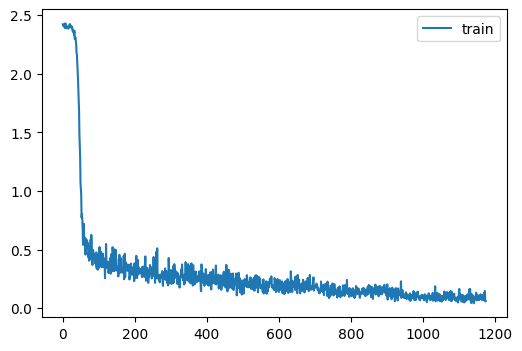

Fit 5 in: 54.42s, setup: 0.00s, 10.58 ± 0.09s per epoch, 0.04 ± 0.01s per batch


In [35]:
import dadaptation
RNG.set_seed(1)
learn = run(timm_model('resnet18d', upscale32.bilinear(2),leaky=0.0),
            opt_func=partial(dadaptation.DAdaptAdam, weight_decay=0.0), base_lr=1)


Reseed: 1
Reseed: 1
Batch size 256
Reseed: 1


accuracy,loss,epoch,train
0.768,0.644,0,train
0.802,0.580,0,eval
0.898,0.287,1,train
0.903,0.277,1,eval
0.923,0.213,2,train
0.901,0.287,2,eval
0.942,0.156,3,train
0.930,0.195,3,eval
0.960,0.107,4,train
0.936,0.181,4,eval


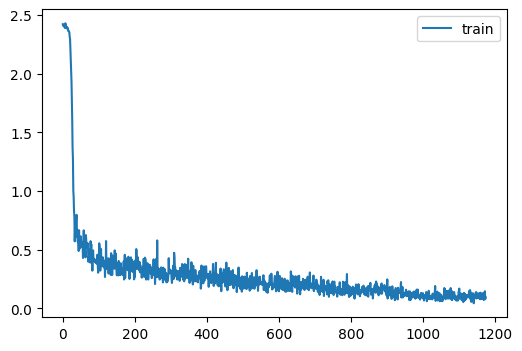

Fit 5 in: 54.52s, setup: 0.00s, 10.60 ± 0.02s per epoch, 0.04 ± 0.00s per batch


In [47]:
import dadaptation
RNG.set_seed(1)
learn = run(timm_model('resnet18d', upscale32.bilinear(2),leaky=0.0),
            opt_func=partial(dadaptation.DAdaptAdam, weight_decay=0.0), base_lr=2)

Reseed: 1
Batch size 256
Reseed: 1


accuracy,loss,epoch,train
0.648,0.980,0,train
0.863,0.377,0,eval
0.882,0.323,1,train
0.877,0.362,1,eval
0.897,0.282,2,train
0.893,0.311,2,eval
0.908,0.253,3,train
0.888,0.328,3,eval
0.914,0.236,4,train
0.895,0.289,4,eval


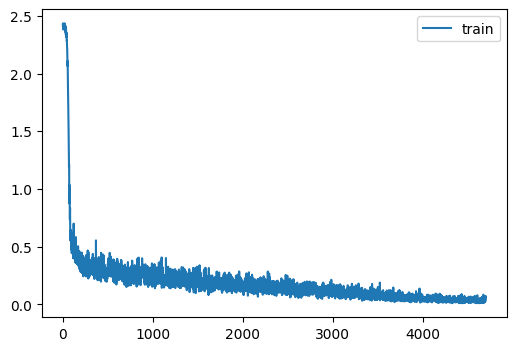

Fit 20 in: 224.81s, setup: 0.00s, 10.94 ± 0.02s per epoch, 0.04 ± 0.00s per batch
Reseed: 1
Reseed: 1
TTA: 0.9485


In [45]:
learn = run(timm_model('resnet18d', upscale32.bilinear(2), leaky=0.0),
            get_augcb(
                transforms.RandomCrop(28, padding=1, fill=-0.800000011920929),
                upscale32.bilinear(2),
                transforms.RandomRotation(1, fill=-0.800000011920929, expand=True, interpolation=transforms.InterpolationMode.BILINEAR),
                transforms.RandomHorizontalFlip(0.5)), 
                opt_func=partial(dadaptation.DAdaptAdam, weight_decay=0.0), base_lr=1,epochs=20, tta=True)

Reseed: 1
Batch size 256
Reseed: 1


accuracy,loss,epoch,train
0.536,1.274,0,train
0.826,0.502,0,eval
0.837,0.440,1,train
0.839,0.528,1,eval
0.863,0.372,2,train
0.839,0.499,2,eval
0.878,0.335,3,train
0.887,0.335,3,eval
0.885,0.314,4,train
0.774,0.701,4,eval


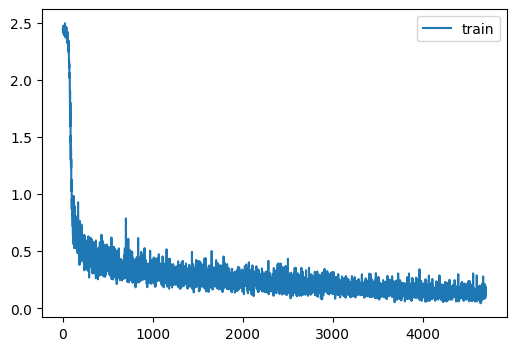

Fit 20 in: 225.86s, setup: 0.00s, 10.99 ± 0.02s per epoch, 0.04 ± 0.00s per batch
Reseed: 1
Reseed: 1
TTA: 0.9469


In [54]:
learn = run(timm_model('resnet18d', upscale32.bilinear(2), leaky=0.0,  drop_rate=0.4),
            get_augcb(
                transforms.RandomCrop(28, padding=1, fill=-0.800000011920929),
                upscale32.bilinear(2),
                transforms.RandomRotation(1, fill=-0.800000011920929, expand=True, interpolation=transforms.InterpolationMode.BILINEAR),
                transforms.RandomHorizontalFlip(0.5),
                RandErase(pct=0.3)),
            opt_func=partial(dadaptation.DAdaptAdam, weight_decay=0.0), base_lr=1,
            epochs=20, tta=True)

In [59]:
from miniai.mixup import MixUpCB

In [63]:
MixedPrecision??

Init signature: MixedPrecision(n_inp=1)
Docstring:      <no docstring>
Source:        
class MixedPrecision(TrainCB):
    order = DeviceCB.order+10
    
    def before_fit(self, learn): self.scaler = torch.cuda.amp.GradScaler()

    def before_batch(self, learn):
        self.autocast = torch.autocast("cuda", dtype=torch.float16)
        self.autocast.__enter__()

    def after_loss(self, learn): self.autocast.__exit__(None, None, None)
        
    def backward(self, learn): self.scaler.scale(learn.loss).backward()

    def step(self, learn):
        self.scaler.step(learn.opt)
        self.scaler.update()
File:           ~/workspace/part2/course22p2/miniai/accel.py
Type:           type
Subclasses:     MixUpFP16CB

In [66]:
clean_mem(); clean_tb(); clean_ipython_hist()

In [64]:
class MixUpFP16CB(MixUpCB, AccelerateCB): pass

Reseed: 1
Batch size 256
Reseed: 1


accuracy,loss,epoch,train
0.524,1.668,0,train
0.855,0.491,0,eval
0.787,1.173,1,train
0.868,0.414,1,eval
0.811,1.113,2,train
0.864,0.458,2,eval
0.828,1.073,3,train
0.897,0.390,3,eval
0.830,1.061,4,train
0.903,0.385,4,eval


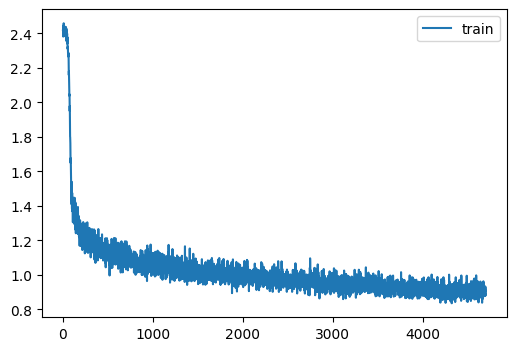

Fit 20 in: 226.60s, setup: 0.00s, 11.02 ± 0.08s per epoch, 0.05 ± 0.00s per batch
Reseed: 1
Reseed: 1
TTA: 0.9498


In [67]:
learn = run(timm_model('resnet18d', upscale32.bilinear(2), leaky=0.0,  drop_rate=0.4),
            get_augcb(
                transforms.RandomCrop(28, padding=1, fill=-0.800000011920929),
                upscale32.bilinear(2),
                transforms.RandomHorizontalFlip(0.5),
                RandErase(pct=0.2)),
            train_cb=MixUpFP16CB(0.4, use_prev=True, label_smoothing=0.1),
            opt_func=partial(dadaptation.DAdaptAdam, weight_decay=0.0), base_lr=1,
            epochs=20, tta=True)

Reseed: 1
Batch size 256
Reseed: 1


accuracy,loss,epoch,train
0.620,1.036,0,train
0.798,0.629,0,eval
0.853,0.400,1,train
0.843,0.482,1,eval
0.889,0.302,2,train
0.763,0.794,2,eval
0.911,0.244,3,train
0.922,0.225,3,eval
0.921,0.211,4,train
0.929,0.203,4,eval


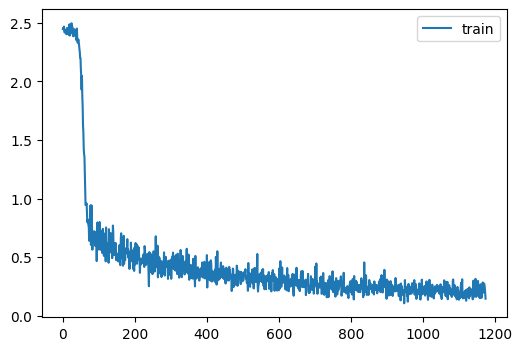

Fit 5 in: 57.49s, setup: 0.00s, 11.15 ± 0.11s per epoch, 0.04 ± 0.01s per batch
Reseed: 1
Reseed: 1
TTA: 0.9296


In [70]:
# does acclerate works as good as autocast
learn = run(timm_model('resnet18d', upscale32.bilinear(2), leaky=0.0,  drop_rate=0.4),
            get_augcb(
                transforms.RandomCrop(28, padding=1, fill=-0.800000011920929),
                upscale32.bilinear(2),
                transforms.RandomRotation(1, fill=-0.800000011920929, expand=True, interpolation=transforms.InterpolationMode.BILINEAR),
                transforms.RandomHorizontalFlip(0.5),
                RandErase(pct=0.2)),
            train_cb=AccelerateCB(),
            opt_func=partial(dadaptation.DAdaptAdam, weight_decay=0.0), base_lr=1,
            epochs=5, tta=True)

Reseed: 1
Batch size 256
Reseed: 1


accuracy,loss,epoch,train
0.620,1.034,0,train
0.835,0.462,0,eval
0.854,0.401,1,train
0.884,0.367,1,eval
0.889,0.302,2,train
0.902,0.278,2,eval
0.911,0.244,3,train
0.922,0.222,3,eval
0.922,0.211,4,train
0.928,0.203,4,eval


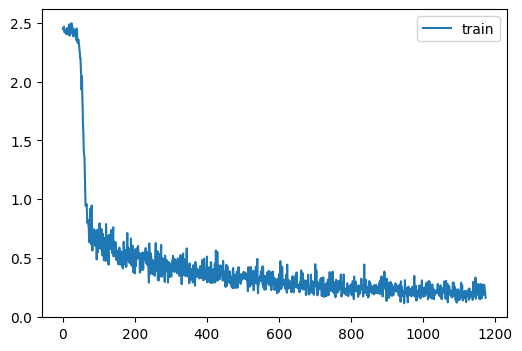

Fit 5 in: 56.67s, setup: 0.00s, 11.03 ± 0.12s per epoch, 0.04 ± 0.01s per batch
Reseed: 1
Reseed: 1
TTA: 0.9296


In [73]:
# does acclerate works as good as autocast
learn = run(timm_model('resnet18d', upscale32.bilinear(2), leaky=0.0,  drop_rate=0.4),
            get_augcb(
                transforms.RandomCrop(28, padding=1, fill=-0.800000011920929),
                upscale32.bilinear(2),
                transforms.RandomRotation(1, fill=-0.800000011920929, expand=True, interpolation=transforms.InterpolationMode.BILINEAR),
                transforms.RandomHorizontalFlip(0.5),
                RandErase(pct=0.2)),
            #train_cb=AccelerateCB(),
            opt_func=partial(dadaptation.DAdaptAdam, weight_decay=0.0), base_lr=1,
            epochs=5, tta=True)

Reseed: 1
Batch size 256
Reseed: 1


accuracy,loss,epoch,train
0.567,1.172,0,train
0.331,4.250,0,eval
0.659,0.919,1,train
0.334,2.390,1,eval
0.728,0.733,2,train
0.352,3.375,2,eval
0.779,0.593,3,train
0.767,0.626,3,eval
0.824,0.484,4,train
0.841,0.423,4,eval


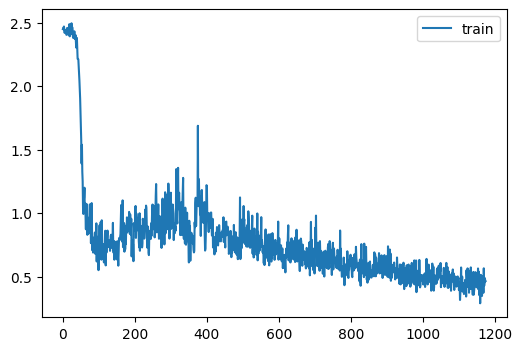

Fit 5 in: 57.99s, setup: 0.00s, 11.29 ± 0.08s per epoch, 0.05 ± 0.00s per batch
Reseed: 1
Reseed: 1
TTA: 0.8444


In [75]:
# what weight decay will do to DadaptAdam, (it matches Adam then), I remember it being worse for DadaptAdam and better for Adam
learn = run(timm_model('resnet18d', upscale32.bilinear(2), leaky=0.0,  drop_rate=0.4),
            get_augcb(
                transforms.RandomCrop(28, padding=1, fill=-0.800000011920929),
                upscale32.bilinear(2),
                transforms.RandomRotation(1, fill=-0.800000011920929, expand=True, interpolation=transforms.InterpolationMode.BILINEAR),
                transforms.RandomHorizontalFlip(0.5),
                RandErase(pct=0.2)),
            train_cb=AccelerateCB(),
            opt_func=partial(dadaptation.DAdaptAdam,weight_decay=0.001), base_lr=1,
            epochs=5, tta=True)

### 50 epAccelerateCB

Reseed: 1
Batch size 256
Reseed: 1


accuracy,loss,epoch,train
0.514,1.686,0,train
0.842,0.491,0,eval
0.789,1.173,1,train
0.881,0.417,1,eval
0.811,1.116,2,train
0.874,0.417,2,eval
0.826,1.081,3,train
0.904,0.380,3,eval
0.830,1.063,4,train
0.905,0.349,4,eval


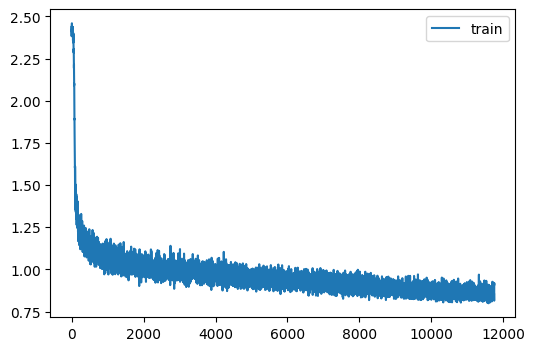

Fit 50 in: 567.19s, setup: 0.00s, 11.01 ± 0.05s per epoch, 0.04 ± 0.00s per batch
Reseed: 1
Reseed: 1
TTA: 0.956


In [76]:
learn = run(timm_model('resnet18d', upscale32.bilinear(2), leaky=0.0,  drop_rate=0.4),
            get_augcb(
                transforms.RandomCrop(28, padding=1, fill=-0.800000011920929),
                upscale32.bilinear(2),
                transforms.RandomHorizontalFlip(0.5),
                RandErase(pct=0.2)),
            train_cb=MixUpFP16CB(0.4, use_prev=True, label_smoothing=0.1),
            opt_func=partial(dadaptation.DAdaptAdam, weight_decay=0.0), base_lr=1,
            epochs=50, tta=True)

Reseed: 1
Batch size 256
Reseed: 1


accuracy,loss,epoch,train
0.519,1.678,0,train
0.824,0.534,0,eval
0.772,1.215,1,train
0.869,0.442,1,eval
0.797,1.151,2,train
0.874,0.414,2,eval
0.814,1.114,3,train
0.890,0.391,3,eval
0.818,1.098,4,train
0.890,0.408,4,eval


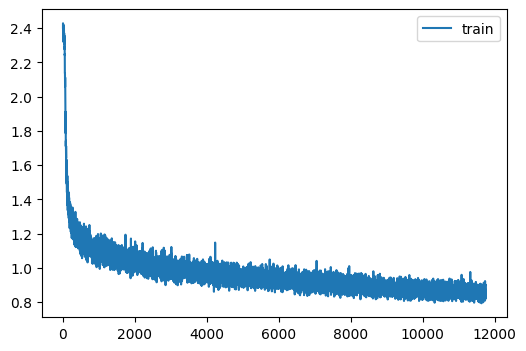

Fit 50 in: 1322.20s, setup: 0.00s, 25.69 ± 0.08s per epoch, 0.11 ± 0.00s per batch
Reseed: 1
Reseed: 1
TTA: 0.9582


In [97]:
learn = run(timm_model('resnet50d', upscale32.bilinear(2), leaky=0.0,  drop_rate=0.4),
            get_augcb(
                transforms.RandomCrop(28, padding=1, fill=-0.800000011920929),
                upscale32.bilinear(2),
                transforms.RandomHorizontalFlip(0.5),
                RandErase(pct=0.2)),
            train_cb=MixUpFP16CB(0.4, use_prev=True, label_smoothing=0.1),
            opt_func=partial(dadaptation.DAdaptAdam, weight_decay=0.0), base_lr=1,
            epochs=50, tta=True)

In [115]:
def save(learn, name):
    from accelerate import Accelerator
    mdl_path = Path.home()/"models"/"fmnist"
    mdl_path.mkdir(parents=True,exist_ok=True)
    model=learn.cbs[-1].acc.unwrap_model(learn.model)
    state_dict = model.state_dict()
    learn.cbs[-1].acc.save(state_dict,  mdl_path/name)
#save(learn, "resnet50d_50ep_mixup.pkl")

In [119]:
clean_ipython_hist()

Reseed: 1
Batch size 256
Reseed: 1


accuracy,loss,epoch,train
0.562,1.609,0,train
0.857,0.490,0,eval
0.810,1.128,1,train
0.891,0.390,1,eval
0.826,1.084,2,train
0.874,0.429,2,eval
0.839,1.051,3,train
0.901,0.363,3,eval
0.843,1.038,4,train
0.899,0.363,4,eval


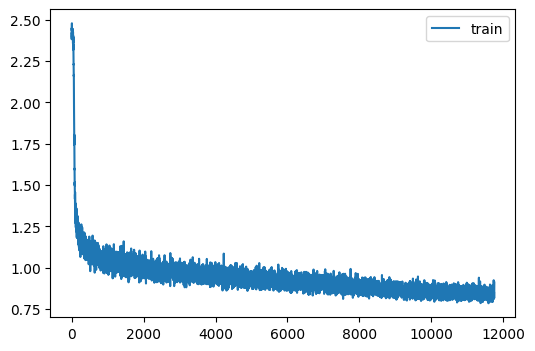

Fit 50 in: 565.24s, setup: 0.00s, 10.97 ± 0.06s per epoch, 0.04 ± 0.00s per batch
Reseed: 1
Reseed: 1
TTA: 0.9563


In [120]:
learn = run(timm_model('resnet18d', upscale32.bilinear(2), leaky=0.0,  drop_rate=0.4),
            get_augcb(
                transforms.RandomCrop(28, padding=1, fill=-0.800000011920929),
                transforms.RandomHorizontalFlip(0.5),
                RandErase(pct=0.1)),
            train_cb=MixUpFP16CB(0.4, use_prev=True, label_smoothing=0.1),
            opt_func=partial(dadaptation.DAdaptAdam, weight_decay=0.0), base_lr=1,
            epochs=50, tta=True)

In [121]:
#save(learn, "resnet18d_50ep_mixup_smallerase.pkl")

In [122]:
### Check general relu with resnet 18d

In [124]:
clean_tb()

Reseed: 1
Batch size 256
Reseed: 1


accuracy,loss,epoch,train
0.621,1.312,0,train
0.799,0.581,0,eval
0.854,0.424,1,train
0.840,0.439,1,eval
0.884,0.330,2,train
0.868,0.365,2,eval
0.899,0.286,3,train
0.893,0.300,3,eval
0.909,0.258,4,train
0.896,0.293,4,eval


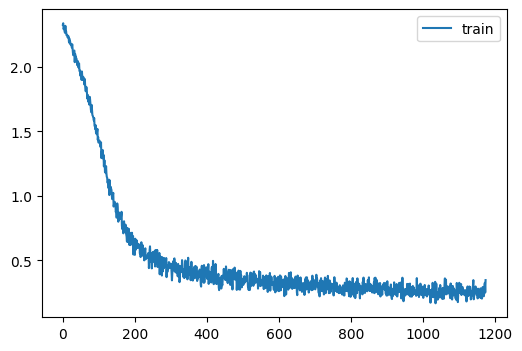

Fit 5 in: 33.75s, setup: 0.00s, 6.46 ± 0.09s per epoch, 0.03 ± 0.00s per batch


In [126]:
learn = run(timm_model('resnet18d', upscale32.bilinear(2),leaky=None))

Reseed: 1
Batch size 256
Reseed: 1


accuracy,loss,epoch,train
0.595,1.360,0,train
0.808,0.550,0,eval
0.860,0.402,1,train
0.842,0.454,1,eval
0.887,0.317,2,train
0.877,0.334,2,eval
0.901,0.277,3,train
0.893,0.299,3,eval
0.911,0.250,4,train
0.898,0.286,4,eval


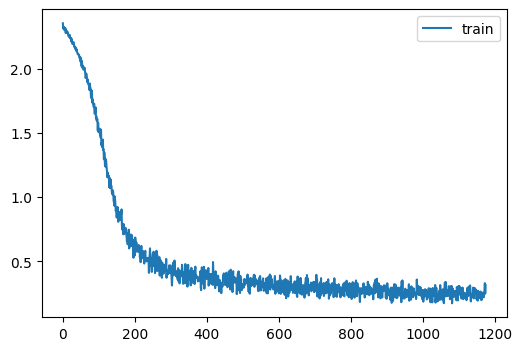

Fit 5 in: 34.84s, setup: 0.00s, 6.60 ± 0.17s per epoch, 0.03 ± 0.01s per batch


In [125]:
learn = run(timm_model('resnet18d', upscale32.bilinear(2), act_layer=lambda inplace:GeneralRelu(leak=0.1, sub=0.4), 
            leaky=0.1, ))

In [131]:
# possible broken init, need to rerun it was aroudn 90% at 50 epoch
learn = run(timm_model('resnet50d', upscale32.bilinear(2), act_layer=lambda inplace:GeneralRelu(leak=0.1, sub=0.4), 
            leaky=0.1, drop_rate=0.4),
            get_augcb(
                transforms.RandomCrop(28, padding=1, fill=-0.800000011920929),
                upscale32.bilinear(2),
                transforms.RandomHorizontalFlip(0.5),
                RandErase(pct=0.2)),
            train_cb=MixUpFP16CB(0.4, use_prev=True, label_smoothing=0.1),
            opt_func=partial(dadaptation.DAdaptAdam, weight_decay=0.0), base_lr=1,
            epochs=50, tta=True)

In [ ]:
save(learn, "resnet50d_50ep_mixup_general_relu.pkl")

In [ ]:
learn = run(timm_model('resnet50d', upscale32.bilinear(2), act_layer=lambda inplace:GeneralRelu(leak=0.1, sub=0.4), 
            leaky=0.1, drop_rate=0.4),
            get_augcb(
                transforms.RandomCrop(28, padding=1, fill=-0.800000011920929),
                upscale32.bilinear(2),
                transforms.RandomHorizontalFlip(0.5),
                RandErase(pct=0.2)),
            train_cb=MixUpFP16CB(0.4, use_prev=True, label_smoothing=0.1),
            opt_func=partial(dadaptation.DAdaptAdam, weight_decay=0.0), base_lr=1,
            epochs=50, tta=True)

### old experiments to reorganize delete

### Augment + curriculum

Reseed: 1
duplicate key cbs 
Batch size 256
Reseed: 1


accuracy,loss,epoch,train
0.802,0.563,0,train
0.822,0.529,0,eval
0.878,0.334,1,train
0.850,0.429,1,eval
0.907,0.252,2,train
0.912,0.238,2,eval
0.925,0.199,3,train
0.929,0.197,3,eval
0.942,0.157,4,train
0.936,0.179,4,eval


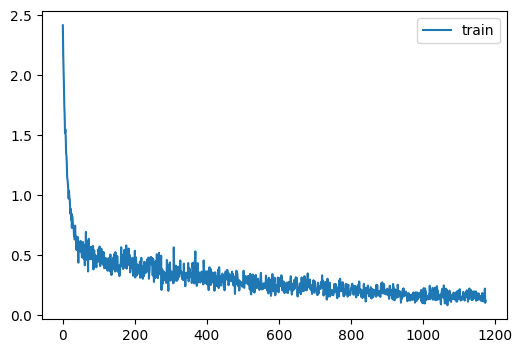

Fit 5 in: 35.44s, setup: 0.01s, 6.76 ± 0.16s per epoch, 0.03 ± 0.01s per batch


In [40]:
learn = run(timm_model('resnet18d', upscale32.bilinear(2), leaky=0.0),
            get_augcb(transforms.RandomCrop(28, padding=1, fill=-0.800000011920929), transforms.RandomHorizontalFlip(0.5)),
            curriculum())

Reseed: 1
duplicate key cbs 
Batch size 256
Reseed: 1


accuracy,loss,epoch,train
0.833,0.483,0,train
0.874,0.374,0,eval
0.874,0.342,1,train
0.896,0.288,1,eval
0.908,0.250,2,train
0.917,0.228,2,eval
0.928,0.195,3,train
0.929,0.194,3,eval
0.942,0.154,4,train
0.937,0.173,4,eval


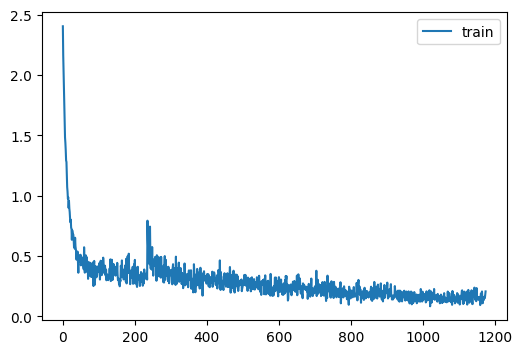

Fit 5 in: 35.25s, setup: 0.00s, 6.73 ± 0.10s per epoch, 0.03 ± 0.01s per batch


In [42]:
learn = run(timm_model('resnet18d', upscale32.bilinear(2), leaky=0.0),
            get_augcb(transforms.RandomCrop(28, padding=1, fill=-0.800000011920929), transforms.RandomHorizontalFlip(0.5), delay=1),
            curriculum())

Reseed: 1
duplicate key cbs 
Batch size 256
Reseed: 1


accuracy,loss,epoch,train
0.833,0.483,0,train
0.874,0.374,0,eval
0.885,0.314,1,train
0.893,0.300,1,eval
0.913,0.236,2,train
0.910,0.253,2,eval
0.933,0.185,3,train
0.931,0.187,3,eval
0.948,0.141,4,train
0.939,0.172,4,eval


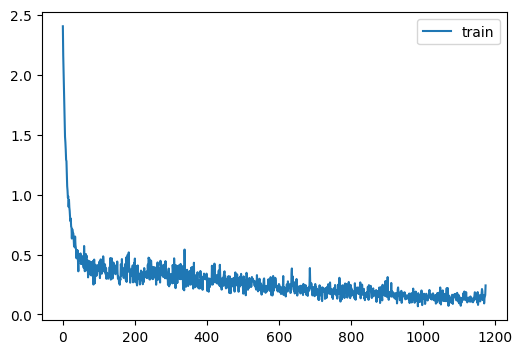

Fit 5 in: 35.36s, setup: 0.00s, 6.74 ± 0.11s per epoch, 0.03 ± 0.01s per batch


In [44]:
learn = run(timm_model('resnet18d', upscale32.bilinear(2), leaky=0.0),
            get_augcb(transforms.RandomCrop(28, padding=1, fill=-0.800000011920929), delay=1),
            curriculum())

### TommyC OneCycleWithPlateau 

In [135]:
class OneCycleLRWithPlateau(lr_scheduler.OneCycleLR):
    def __init__(self, *args, pct_start=0.1, pct_plateau=0.2, **kwargs):
        kwargs["pct_start"] = pct_start
        super(OneCycleLRWithPlateau, self).__init__(*args, **kwargs)
        self._schedule_phases = [
            {
                'end_step': float(pct_start * self.total_steps) - 1,
                'start_lr': 'initial_lr',
                'end_lr': 'max_lr',
                'start_momentum': 'max_momentum',
                'end_momentum': 'base_momentum',
            },
            {
                'end_step': float((pct_start + pct_plateau) * self.total_steps) - 2,
                'start_lr': 'max_lr',
                'end_lr': 'max_lr',
                'start_momentum': 'base_momentum',
                'end_momentum': 'base_momentum',
            },
            {
                'end_step': self.total_steps - 1,
                'start_lr': 'max_lr',
                'end_lr': 'initial_lr',
                'start_momentum': 'base_momentum',
                'end_momentum': 'max_momentum',
            },
        ]

Reseed: 1
Batch size 256
Reseed: 1


accuracy,loss,epoch,train
0.838,0.463,0,train
0.895,0.298,0,eval
0.911,0.246,1,train
0.891,0.301,1,eval
0.925,0.204,2,train
0.911,0.244,2,eval
0.945,0.151,3,train
0.933,0.186,3,eval
0.965,0.094,4,train
0.940,0.175,4,eval


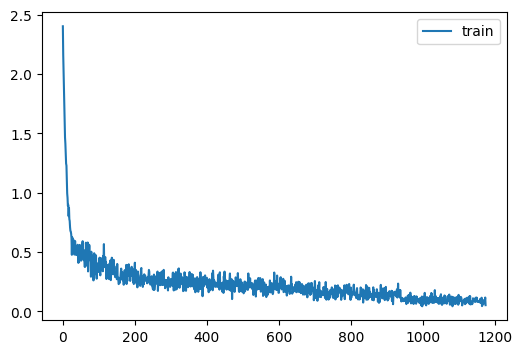

Fit 5 in: 37.64s, setup: 0.00s, 7.19 ± 0.18s per epoch, 0.03 ± 0.01s per batch


In [137]:
# lr=0.02, with Plateau
learn = run(**timm_model('resnet18d', upscale32.bilinear(2)), leaky=0.0, 
            dls=CustomDataLoader.from_dd(tds.cached, bs, num_workers=0),
            sched_fn=partial(OneCycleLRWithPlateau, pct_start=0.1, pct_plateau=0.3))

Reseed: 1
Batch size 256
Reseed: 1


accuracy,loss,epoch,train
0.827,0.502,0,train
0.869,0.381,0,eval
0.912,0.239,1,train
0.913,0.238,1,eval
0.928,0.194,2,train
0.916,0.223,2,eval
0.949,0.140,3,train
0.933,0.188,3,eval
0.969,0.087,4,train
0.942,0.172,4,eval


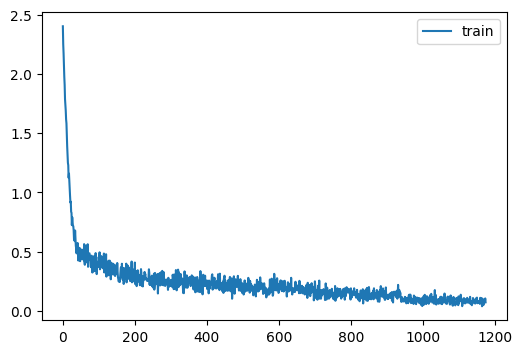

Fit 5 in: 38.09s, setup: 0.00s, 7.27 ± 0.14s per epoch, 0.03 ± 0.01s per batch


In [139]:
# lr=0.01 , with Plateau
learn = run(**timm_model('resnet18d', upscale32.bilinear(2)), leaky=0.0, 
            base_lr=0.01,
            dls=CustomDataLoader.from_dd(tds.cached, bs, num_workers=0),
            sched_fn=partial(OneCycleLRWithPlateau, pct_start=0.1, pct_plateau=0.3))

Reseed: 1
Batch size 256
Reseed: 1


accuracy,loss,epoch,train
0.819,0.545,0,train
0.824,0.476,0,eval
0.902,0.265,1,train
0.909,0.255,1,eval
0.928,0.198,2,train
0.923,0.211,2,eval
0.949,0.140,3,train
0.934,0.188,3,eval
0.968,0.090,4,train
0.942,0.172,4,eval


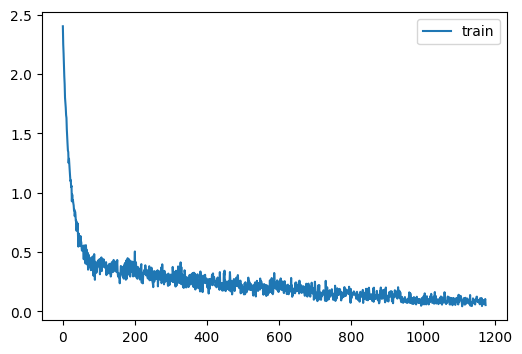

Fit 5 in: 38.49s, setup: 0.01s, 7.35 ± 0.26s per epoch, 0.03 ± 0.01s per batch


In [140]:
# lr=0.01
learn = run(**timm_model('resnet18d', upscale32.bilinear(2)), leaky=0.0, 
            base_lr=0.01,
            dls=CustomDataLoader.from_dd(tds.cached, bs, num_workers=0))

Reseed: 1
Batch size 256
Reseed: 1


accuracy,loss,epoch,train
0.822,0.540,0,train
0.824,0.475,0,eval
0.904,0.263,1,train
0.914,0.244,1,eval
0.928,0.197,2,train
0.912,0.249,2,eval
0.948,0.141,3,train
0.931,0.192,3,eval
0.968,0.088,4,train
0.942,0.172,4,eval


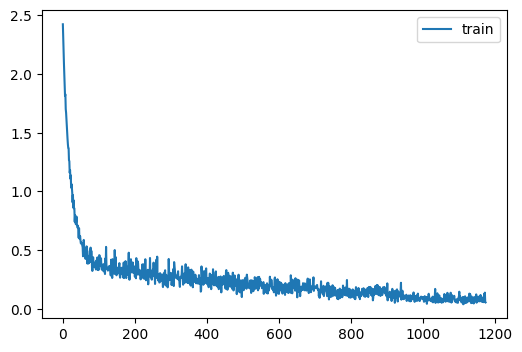

Fit 5 in: 37.17s, setup: 0.00s, 7.12 ± 0.13s per epoch, 0.03 ± 0.01s per batch


In [141]:
learn = run(**timm_model('resnet18d', upscale32.bilinear(2)), leaky=0.0, 
            base_lr=0.01)

### Mixup

In [111]:
from miniai.mixup import MixUpCB

In [113]:
class MixUpFP16CB(MixUpCB, AccelerateCB): pass

Batch size 256


accuracy,loss,epoch,train
0.775,1.212,0,train
0.873,0.555,0,eval
0.842,1.033,1,train
0.892,0.418,1,eval
0.864,0.977,2,train
0.917,0.323,2,eval
0.886,0.936,3,train
0.937,0.279,3,eval
0.907,0.898,4,train
0.944,0.259,4,eval


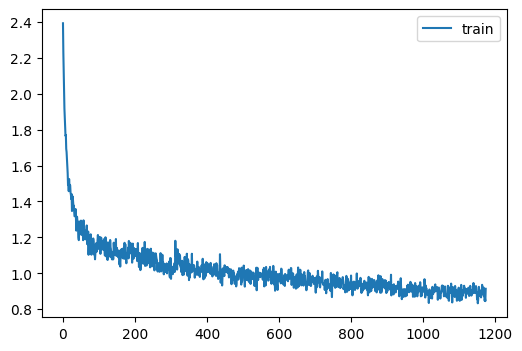

Fit 5 in: 39.19s, setup: 0.00s, 7.49 ± 0.13s per epoch, 0.03 ± 0.01s per batch


In [116]:
learn = run(**timm_model('resnet18d', upscale32.bilinear(2)), 
            leaky=0.0, 
            dls=CustomDataLoader.from_dd(tds.cached, bs, num_workers=0),
            train_cb=MixUpFP16CB(0.4, use_prev=True, label_smoothing=0.1))

Reseed: 1
Batch size 256
Reseed: 1


accuracy,loss,epoch,train
0.775,1.208,0,train
0.715,0.948,0,eval
0.845,1.032,1,train
0.903,0.392,1,eval
0.863,0.983,2,train
0.921,0.317,2,eval
0.884,0.936,3,train
0.930,0.294,3,eval
0.906,0.900,4,train
0.939,0.263,4,eval


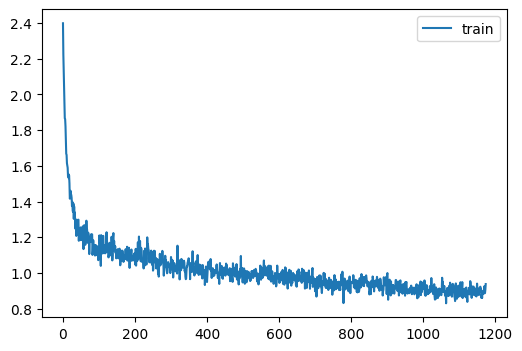

Fit 5 in: 37.70s, setup: 0.00s, 7.22 ± 0.15s per epoch, 0.03 ± 0.01s per batch


In [128]:
# no curriculum learning
learn = run(**timm_model('resnet18d', upscale32.bilinear(2)), 
            leaky=0.0, 
            train_cb=MixUpFP16CB(0.4, use_prev=True, label_smoothing=0.1))

Reseed: 1
Batch size 256
Reseed: 1


accuracy,loss,epoch,train
0.767,0.924,0,train
0.757,0.834,0,eval
0.834,0.690,1,train
0.893,0.340,1,eval
0.855,0.620,2,train
0.917,0.252,2,eval
0.879,0.560,3,train
0.926,0.215,3,eval
0.900,0.514,4,train
0.940,0.174,4,eval


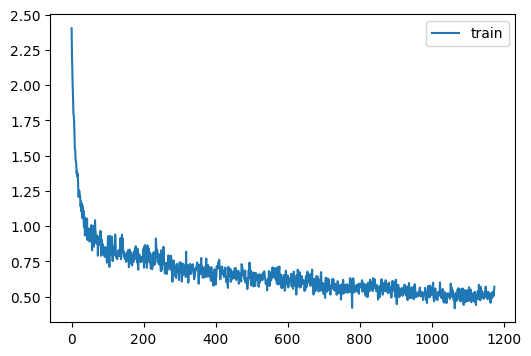

Fit 5 in: 37.83s, setup: 0.00s, 7.24 ± 0.10s per epoch, 0.03 ± 0.00s per batch


In [143]:
# no curriculum learning, no label smoothing
learn = run(**timm_model('resnet18d', upscale32.bilinear(2)), 
            leaky=0.0, 
            train_cb=MixUpFP16CB(0.4, use_prev=True, label_smoothing=0.0))

### Mixup + Aug

In [148]:
def tfm_batch(b, tfm_x=fc.noop, tfm_y = fc.noop): return tfm_x(b[0]),tfm_y(b[1])
def augcb(*ag):
    tfms = nn.Sequential()
    return BatchTransformCB(partial(tfm_batch, tfm_x=tfms), on_val=False)

Reseed: 1
Batch size 256
Reseed: 1


accuracy,loss,epoch,train
0.739,1.284,0,train
0.824,0.568,0,eval
0.818,1.093,1,train
0.878,0.439,1,eval
0.843,1.023,2,train
0.899,0.373,2,eval
0.864,0.981,3,train
0.928,0.291,3,eval
0.880,0.947,4,train
0.933,0.274,4,eval


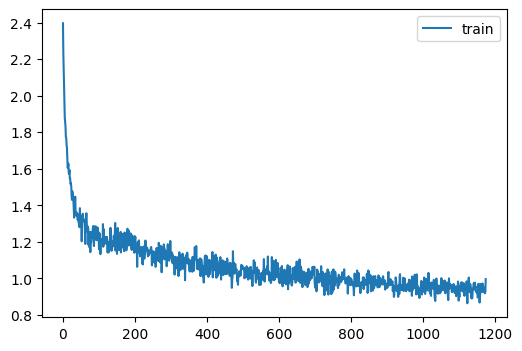

Fit 5 in: 39.14s, setup: 0.00s, 7.48 ± 0.18s per epoch, 0.03 ± 0.01s per batch
Reseed: 1
Reseed: 1
TTA: 0.9352


In [131]:
learn = run(**timm_model('resnet18d', upscale32.bilinear(2)), 
            leaky=0.0, 
            cbs=[augcb(transforms.RandomCrop(28, padding=1),transforms.RandomHorizontalFlip(0.65))],
            dls=CustomDataLoader.from_dd(tds.cached, bs, num_workers=0),
            train_cb=MixUpFP16CB(0.4, use_prev=True, label_smoothing=0.1), tta=True)

Reseed: 1
Batch size 256
Reseed: 1


accuracy,loss,epoch,train
0.743,1.279,0,train
0.819,0.560,0,eval
0.818,1.090,1,train
0.884,0.413,1,eval
0.842,1.029,2,train
0.902,0.359,2,eval
0.865,0.978,3,train
0.924,0.298,3,eval
0.882,0.944,4,train
0.932,0.271,4,eval


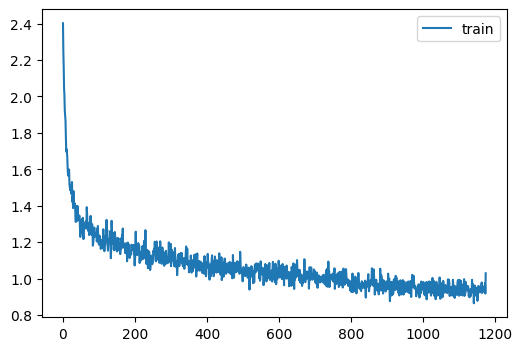

Fit 5 in: 38.57s, setup: 0.00s, 7.39 ± 0.15s per epoch, 0.03 ± 0.01s per batch
Reseed: 1
Reseed: 1
TTA: 0.9347


In [142]:
learn = run(**timm_model('resnet18d', upscale32.bilinear(2)), 
            leaky=0.0, 
            cbs=[augcb(transforms.RandomCrop(28, padding=1),transforms.RandomHorizontalFlip(0.65))],
            train_cb=MixUpFP16CB(0.4, use_prev=True, label_smoothing=0.1), tta=True)

# 20 ep

Reseed: 1
Batch size 256
Reseed: 1


accuracy,loss,epoch,train
0.749,1.267,0,train
0.866,0.485,0,eval
0.819,1.103,1,train
0.875,0.443,1,eval
0.831,1.066,2,train
0.819,0.598,2,eval
0.842,1.036,3,train
0.893,0.393,3,eval
0.849,1.019,4,train
0.909,0.408,4,eval


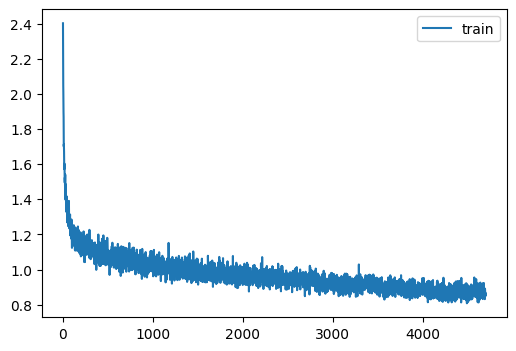

Fit 20 in: 153.54s, setup: 0.00s, 7.34 ± 0.07s per epoch, 0.03 ± 0.00s per batch
Reseed: 1
Reseed: 1
TTA: 0.953


In [146]:
learn = run(**timm_model('resnet18d', upscale32.bilinear(2)), 
            leaky=0.0, 
            cbs=[augcb(transforms.RandomCrop(28, padding=1),transforms.RandomHorizontalFlip(0.65))],
            epochs=20,
            train_cb=MixUpFP16CB(0.4, use_prev=True, label_smoothing=0.1), tta=True)

Reseed: 1
Batch size 256
Reseed: 1


accuracy,loss,epoch,train
0.767,2.259,0,train
0.863,0.544,0,eval
0.818,1.946,1,train
0.865,0.542,1,eval
0.825,1.865,2,train
0.908,0.434,2,eval
0.837,1.795,3,train
0.905,0.407,3,eval
0.844,1.760,4,train
0.870,0.549,4,eval


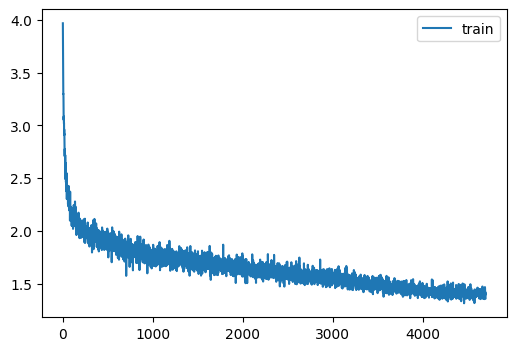

Fit 20 in: 159.55s, setup: 0.00s, 7.66 ± 0.08s per epoch, 0.03 ± 0.00s per batch
Reseed: 1
Reseed: 1
TTA: 0.87


In [150]:
from miniai.mixup import dmce
learn = run(**timm_model('resnet18d', upscale32.bilinear(2)), 
            leaky=0.0, 
            cbs=[augcb(transforms.RandomCrop(28, padding=1),transforms.RandomHorizontalFlip(0.65))],
            epochs=20,
            train_cb=MixUpFP16CB(0.4, use_prev=True, loss_func=dmce, eta=0.1, label_smoothing=0.1), tta=True)

Reseed: 1
Batch size 256
Reseed: 1


accuracy,loss,epoch,train
0.778,1.471,0,train
0.848,0.555,0,eval
0.836,1.278,1,train
0.902,0.409,1,eval
0.843,1.237,2,train
0.912,0.368,2,eval
0.854,1.199,3,train
0.914,0.364,3,eval
0.862,1.181,4,train
0.875,0.469,4,eval


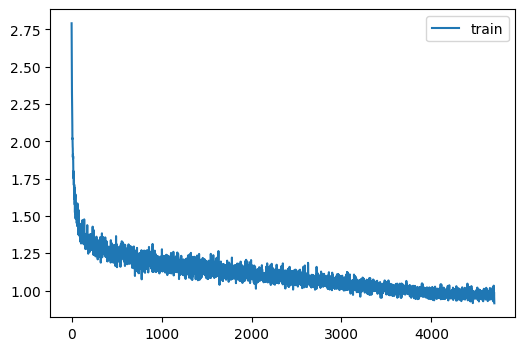

Fit 20 in: 159.23s, setup: 0.00s, 7.64 ± 0.11s per epoch, 0.03 ± 0.01s per batch
Reseed: 1
Reseed: 1
TTA: 0.9296


In [151]:
from miniai.mixup import dmce
learn = run(**timm_model('resnet18d', upscale32.bilinear(2)), 
            leaky=0.0, 
            cbs=[augcb(transforms.RandomCrop(28, padding=1),transforms.RandomHorizontalFlip(0.65))],
            epochs=20,
            train_cb=MixUpFP16CB(0.4, use_prev=True, loss_func=dmce, eta=0.1/4, label_smoothing=0.1), tta=True)

In [147]:
### EP 50

In [ ]:
from miniai.mixup import dmce
learn = run(**timm_model('resnet18d', upscale32.bilinear(2)), 
            leaky=0.0, 
            cbs=[augcb(transforms.RandomCrop(28, padding=1),transforms.RandomHorizontalFlip(0.65))],
            epochs=50,
            train_cb=MixUpFP16CB(0.4, use_prev=True, eta=0.0, label_smoothing=0.1), tta=True)

Reseed: 1
Batch size 256
Reseed: 1
